* Take an ID of a strategy and output dataset.json
* Normalize over any indicators
* Process [x]

# Following experiments with CNN  

Standard imports

**Indicators**  
Function  
Identity  
MA  **(goes together)**  
MACD **(goes together by MACD + SIGNAL nut not between MACDs)**  
StdDev  
BBANDS  
RSI  
UMustache  
LMustache  
CandleSize  
PivotPoint  
PlusDI  
MinusDI  
ADX  
Momentum  
Stochastic  
SMI  
Operator  
Ichimoku  
HLBand  
RCI  
DiffMA  

In [141]:
from database import db_session
from models import Strategy
strategy_id = 1026

try:
    st = db_session.query(Strategy).get(strategy_id)
    mp = st.model_params
    dataset = st.current_dataset.data["data"]
    ca = st.current_algo
    sc = ca.score
    ddd = sc.data
finally:
    db_session.remove()
print(len(dataset))

6


In [142]:
from __future__ import print_function, absolute_import

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# import histdata
import json
import os
import copy

from tseries.chartdata import get_range
import datetime
import calendar
import pytz

from IPython import display
%matplotlib inline
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})

def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

# mp = load_json("/project/exp/list_mp.json")

# h5 = histdata.get_pandadb()
# df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

# start, end = "2016-05-01 01:15:00" , "2016-06-13 04:55:00"

In [143]:
print("ok")

ok


In [144]:
# normalisation functions
def norm(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norm(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center_01(x):
    c = (x - x.min())/(x.max() - x.min())
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [145]:
from ml import preprocess
from histdata import get_pandadb, get_table_name
from tseries.converter import Converter
from tseries.indicators import get_functions

from matplotlib.finance import candlestick2_ohlc

In [146]:
def plot_candles(c):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3],
                      width=0.8, colorup='mediumseagreen', colordown='crimson', alpha=0.9)
    # ax.autoscale_view()
    fig.tight_layout()
    plt.show()

In [147]:
def _only_selected(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    return np.array(t)
def _partial_normalize(cand):
    c = np.array([i["x"] for i in cand])
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6]] = center_01(c[:,[6]])
    c[:,[7]] = center_01(c[:,[7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c
def _only_selected_partial_normalize(cand):
    t = []
    for i in cand:
        if not i["y"][0]>0:
            continue
        t.append(i["x"])
    c = np.array(t)
    c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
    c[:,[4,5]] = center_01(c[:,[4,5]])
    c[:,[6]] = center_01(c[:,[6]])
    c[:,[7]] = center_01(c[:,[7]])
    c[:,[8,9]] = center_01(c[:,[8,9]])
    return c

In [148]:
features = []
for idxi,i in enumerate(mp["features"]):
    if "_dg2" in i["id"]:
        continue
    else:
#         print(i)
        tmp = i
        tmp["normalizers"] = []
        features.append(tmp)
mp["features"] = features
# features

In [208]:
mp = load_json("/project/exp/list_mp_no_norm.json")
indicators = [str(i["id"]) for i in mp["features"]]

In [209]:
indicators

['open_dg1',
 'high_dg1',
 'low_dg1',
 'close_dg1',
 'umustache',
 'lmustache',
 'ma-1',
 'ma-2',
 'macd-3',
 'macd-3-signal']

In [210]:
scaling_list = {"Function": [],"Identity": [],"MA": [],"MACD": [],"StdDev": [],
                "BBANDS": [],"RSI": [],"UMustache": [],"LMustache": [],"CandleSize": [],
                "PivotPoint": [],"PlusDI": [],"MinusDI": [],"ADX": [],"Momentum": [],
                "Stochastic": [],"SMI": [],"Operator": [],"Ichimoku": [],"HLBand": [],
                "RCI": [],"DiffM": [],
                "Mustache": [], #added 
               }

for idxi,i in enumerate(mp["features"]):
    t = i["indicator_type"]
    if t == "Identity":
        scaling_list[t].append(idxi)
    elif "Mustache" in t:
        scaling_list["Mustache"].append(idxi)
    elif t == "MACD":
        if not "-signal" in i["id"]:
            scaling_list[i["id"]] = [idxi]
        else:
            scaling_list[i["id"][:-7]].append(idxi)
    else:
        scaling_list[t].append(idxi)
        
indicators_groups = []
for i in scaling_list.values():
    if i != []:
        indicators_groups.append(i)
indicators_groups

[[8, 9], [0, 1, 2, 3], [4, 5], [6, 7]]

In [211]:
scaling_list

{'ADX': [],
 'BBANDS': [],
 'CandleSize': [],
 'DiffM': [],
 'Function': [],
 'HLBand': [],
 'Ichimoku': [],
 'Identity': [0, 1, 2, 3],
 'LMustache': [],
 'MA': [6, 7],
 'MACD': [],
 'MinusDI': [],
 'Momentum': [],
 'Mustache': [4, 5],
 'Operator': [],
 'PivotPoint': [],
 'PlusDI': [],
 'RCI': [],
 'RSI': [],
 'SMI': [],
 'StdDev': [],
 'Stochastic': [],
 'UMustache': [],
 u'macd-3': [8, 9]}

In [212]:
def plot_ohlc_ind(selected_data,r=-1,indicators=indicators,labels=None):
    r = r if r!=-1 else np.random.choice(len(selected_data))
    c = copy.deepcopy(selected_data[r])
    for i in indicators_groups:
        if len(i) == 4:
            c[:,i] = c[:,i] * 2
        if i == [4,5] or i == [5,4]:
            c[:,i] = c[:,i] /2
#     c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
#     c[:,[4,5]] = c[:,[4,5]] /2
#     c[:,[6,7]] = c[:,[6,7]]
#     c[:,[8,9]] = c[:,[8,9]]

    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,len(c[0])):
        plt.plot(c[:,i],label=indicators[i][:12])
    if not (labels is None): plt.plot(labels[r],'k--',label="Labels",linewidth=2)
    plt.title("Candles & Indicators")
    plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)

    ax.set_xlim(xmin=0)

    plt.show()

In [213]:
mp["symbol"] , mp["timeframe"]

(u'EURUSD', u'5Min')

In [227]:
dataset = load_json("/project/exp/golden_and_dead_cross/year2014.json")["data"]
# dataset_test = load_json("/project/exp/golden_and_dead_cross/year2014_test.json")["data"]
# dataset = load_json("/project/exp/golden_and_dead_cross/year2014.posneg.json")["data"]
# dataset = load_json("/project/exp/beginner/selected_stochastic.json")["data"]
# dataset = load_json("/project/exp/eurusd_15m_ma50_one_top_over_ma.json")["data"]

# mp['symbol'] = "EURUSD"
# mp['timeframe'] = "5Min"

Genereated here: https://app.redash.io/alpaca/queries/7175/source#table

In [215]:
import pandas as pd
list_of_datasets = pd.read_csv("./../../data/List_of datasets_2016_06_17.csv")

list_of_datasets["len_json"] = map(lambda row: len(json.loads(row)["data"]) , list_of_datasets["json"])

list_of_datasets.sort_values("len_json", ascending=False, inplace=True)
list_of_datasets.index = range(len(list_of_datasets))
list_of_datasets.head(5)

,id,json,sharpe_ratio,net_profit,symbol,timeframe,side,key,len_json
0,4073,"{""version"": 1, ""data"": [{""start"": ""2015/04/27 ...",0.057548,1821.0,USDJPY,1Min,long,20160428-163206_slk80-4-app-2-www_b2fb2a70,190
1,2333,"{""version"": 1, ""data"": [{""start"": ""2016/01/15 ...",0.072202,3440.9,USDJPY,1H,short,20160314-170208_slk80-4-app-2-www_9fcaec32,152
2,2333,"{""version"": 1, ""data"": [{""start"": ""2016/01/15 ...",0.054146,5898.5,USDJPY,1H,short,20160314-170208_slk80-4-app-2-www_9fcaec32,152
3,2333,"{""version"": 1, ""data"": [{""start"": ""2016/01/15 ...",0.078459,2284.9,USDJPY,1H,short,20160314-170208_slk80-4-app-2-www_9fcaec32,152
4,2333,"{""version"": 1, ""data"": [{""start"": ""2016/01/15 ...",0.091472,2226.2,USDJPY,1H,short,20160314-170208_slk80-4-app-2-www_9fcaec32,152


In [216]:
if any([i["label"] == ['neg_icon'] for i in dataset]):
    print("Negative inputs present!")

In [228]:
dataset[0],dataset[-1]

({u'end': u'2014/01/02 01:51', u'label': [], u'start': u'2014/01/02 00:10'},
 {u'end': u'2014/12/30 11:11', u'label': [], u'start': u'2014/12/30 07:35'})

In [229]:
%%time

start, end = "2005-01-01 00:00:00" , "2018-12-31 00:00:00"
d_start = datetime.datetime.strptime(start,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
d_end = datetime.datetime.strptime(end,"%Y-%m-%d %H:%M:%S").replace(tzinfo=pytz.utc)
symbol = mp['symbol']
timeframe = mp['timeframe']
# mppp = load_json("/project/exp/list_simple2.json")
indi = mp["features"]
print(symbol,timeframe)
r = get_range(d_start, d_end, symbol, timeframe, indi)

EURUSD 5Min
CPU times: user 35.7 s, sys: 3.27 s, total: 38.9 s
Wall time: 39.5 s


In [230]:
r.keys()

[u'close_dg1',
 u'ma-2',
 u'ma-1',
 u'umustache',
 u'lmustache',
 u'low_dg1',
 u'macd-3',
 'High',
 u'open_dg1',
 u'high_dg1',
 'Date',
 'Close',
 'Open',
 u'macd-3-signal',
 'Low']

In [231]:
indicators

['open_dg1',
 'high_dg1',
 'low_dg1',
 'close_dg1',
 'umustache',
 'lmustache',
 'ma-1',
 'ma-2',
 'macd-3',
 'macd-3-signal']

In [232]:
df = pd.DataFrame.from_dict(r)
df["Date"] = df["Date"].apply(lambda x: datetime.datetime.fromtimestamp(x/1e9))
df = df.set_index("Date")
# df = df[["Open","High","Low","Close","umustache","lmustache","ma-1","ma-2","macd-3","macd-3-signal"]]
# df = df[indicators]
df = df[["Open","High","Low","Close"]+indicators[4:]]
df.head(5)

,Open,High,Low,Close,umustache,lmustache,ma-1,ma-2,macd-3,macd-3-signal
Date,,,,,,,,,,
2005-01-03 06:45:00,1.3552,1.3552,1.3552,1.3552,0.0000,0.0000,1.356039,1.360677,-0.000090,0.000127
2005-01-03 06:50:00,1.3552,1.3552,1.3462,1.3465,0.0000,0.0003,1.355844,1.360597,-0.000823,-0.000063
2005-01-03 06:55:00,1.3466,1.3477,1.3464,1.3477,0.0000,0.0002,1.355668,1.360524,-0.001292,-0.000309
2005-01-03 07:00:00,1.3476,1.3479,1.3473,1.3477,0.0002,0.0003,1.355500,1.360451,-0.001645,-0.000576
2005-01-03 07:05:00,1.3476,1.3477,1.3471,1.3472,0.0001,0.0001,1.355325,1.360376,-0.001942,-0.000849


In [233]:
def easing(t, b, c, d):
    t /= d
    return c * t * t + b

def process_range(r, df, align, justify_right=False):
    startidx = df[df.index < r["start"]].shape[0]
    endidx = df[df.index <= r["end"]].shape[0] # !

    datalen = endidx - startidx
    if datalen >= align:
        startidx = endidx - align + 1
        datalen = endidx - startidx
    assert (datalen < align)

    if justify_right:
        leftmost = endidx - align
        rightmost = endidx
        start_margin = datalen
    else:
        start_margin = (align - datalen) / 2
        leftmost = max(startidx - start_margin, 0)
        rightmost = min(leftmost + align, df.shape[0])

        if rightmost - leftmost < align:
            # shift back the leftmost point
            leftmost -= align - (rightmost - leftmost)

    assert (leftmost >= 0)
    assert (rightmost <= df.shape[0])
    assert (rightmost - leftmost == align)

    mini_df = df[leftmost:rightmost]
    x_values = mini_df
    
    d = datalen
    t = np.arange(1, d + 1, dtype=np.float32)
    y = easing(t, 0.0, t / d, d)
    y_values = np.zeros(align, dtype=np.float32)
    if justify_right:
        y_values[-datalen:] = y
    else:
        y_values[start_margin:start_margin+datalen] = y

    return x_values.astype(np.float32), y_values

def select_normalize_from_df(r, df, align, justify_right=False):
    
    t,y = process_range(r, df, align, justify_right=justify_right)

    c = t.values
    for i in indicators_groups:
        c[:,i] = center_01(c[:,i])
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]]     = center_01(c[:,[4,5]])
#     c[:,[6]]       = center_01(c[:,[6]])
#     c[:,[7]]       = center_01(c[:,[7]])
#     c[:,[8,9]]     = center_01(c[:,[8,9]])

    return c.astype(np.float32),y

def normalize_array(df):
    
    c = copy.deepcopy(df.values)
    for i in indicators_groups:
        c[:,i] = center_01(c[:,i])
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]]     = center_01(c[:,[4,5]])
#     c[:,[6]]       = center_01(c[:,[6]])
#     c[:,[7]]       = center_01(c[:,[7]])
#     c[:,[8,9]]     = center_01(c[:,[8,9]])

    return c.astype(np.float32)

In [236]:
len(df)

852088

In [237]:
%%time
align = 25
justify_right = True

tmp = zip(*[select_normalize_from_df(j,df,align,justify_right=justify_right) for j in dataset])
selected_data, labels = np.array(tmp[0]), np.array(tmp[1])
print(selected_data.shape)
print(max([len(i.nonzero()[0]) for i in labels]))

(203, 25, 10)
24


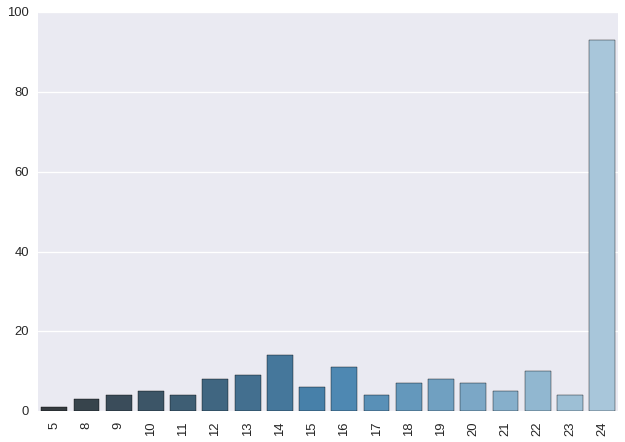

In [238]:
t = np.array([len(i.nonzero()[0]) for i in labels])
x = sorted(list(set(t)))
g = sns.barplot(y = [len(t[t[:]==i]) for i in x],
            x = x,
            ci=None,orient="v",palette="Blues_d")
g.set_xticklabels(x,rotation=90)
plt.show()

In [239]:
len(df)

852088

In [240]:
%%time
align = min(100000, len(df))
justify_right = False
ddd,_ = select_normalize_from_df({u'end': u'2015/01/01 17:45', u'start': u'2005/03/23 15:00'},
                                 df,align,justify_right=justify_right)
data_indicators = np.array([ddd])
print(data_indicators.shape)

(1, 100000, 10)
CPU times: user 248 ms, sys: 172 ms, total: 420 ms
Wall time: 419 ms


In [241]:
# !pip install pandas_profiling
# import pandas_profiling
# pandas_profiling.ProfileReport(pd.DataFrame(data=[len(i) for i in selected_data]))

# zip(selected_data[0][0],indicators)

### What does our data look like?

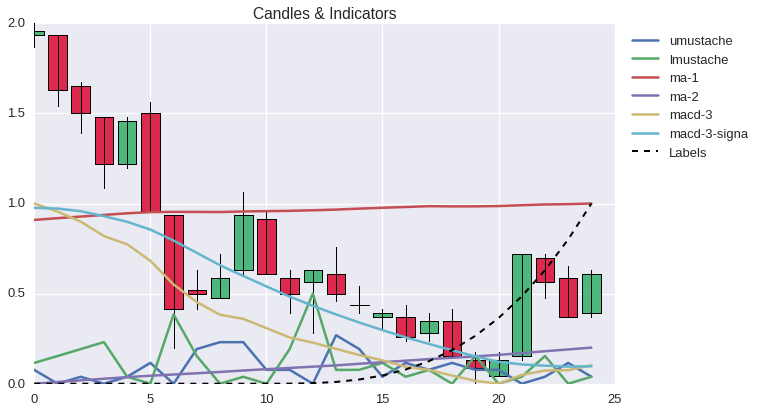

In [242]:
# random sample
plot_ohlc_ind(selected_data, r=-1, indicators=indicators, labels=labels)

# 1D Convolution
I adapt the kernel size, strides and padding, and input a 2D matrix with one of the dimension=1; simple.

In [37]:
#!pip install --upgrade chainer > /dev/null

In [244]:
import pickle
import numpy as np
# from PIL import Image
import os
# from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function
from chainer import initializers

import chainer.functions as F
import chainer.links as L


# import numpy

Compute output size, which is obtained with:  
$$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$

In [245]:
def get_output_size(*args):
    """ (in, [l_pad, l_k, l_ch, l_st], [l_pad, l_k, l_ch, l_st], ...)
    Example:
        (input_size,
         [layer_1_padding, layer_1_filter, layer_1_channel, layer_1_stride],
         [layer_2_padding, layer_2_filter, layer_2_channel, layer_2_stride],
         ...
         [layer_N_padding, layer_N_filter, layer_N_channel, layer_N_stride],
        )
        
    Computed as:
    $$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$
    """
    out = -1
    previous = 1
    for idx,i in enumerate(args):
        if idx==0:
            out=i
            continue
        out = ( (out/previous + 2*i[0] - i[1]) / i[3] + 1) * i[2]
        previous = i[2]
    return out

**Use global average pooling to get rid of FC layer**  
[Network in network paper](http://image-net.org/challenges/LSVRC/2014/slides/ILSVRC2014_NUS_release.pdf)  
[slide 6](https://arxiv.org/pdf/1312.4400.pdf)  
visualize with http://cnnlocalization.csail.mit.edu/

In [246]:
# Yup, always use it. Marginal speedup (~5-10%). Somewhat more stable training?
# use_cudnn = True

# params
input_size = selected_data.shape[1]
input_channels = selected_data.shape[2] #10
ch1,ch2,ch3,ch4 = 32,64,128,64
# k1,k2,k3,k4 = 3,5,8,8
# k1,k2,k3,k4 = 12,8,5,3
k1,k2,k3,k4 = 11,5,3,3
st1,st2,st3,st4 = 3,2,1,2
p1,p2,p3,p4 = 2,2,2,2

fullco_val = get_output_size(input_size,
                             [p1,k1,ch1,st1],
                             [p2,k2,ch2,st2],
                             [p3,k3,ch3,st3],
                            )
# fullco_val = get_output_size(input_size,
#                              [p1,k1,ch1,st1], [p1,k1,ch1,st1],
#                              [p2,k2,ch2,st2], [p2,k2,ch2,st2],
#                              [p3,k3,ch3,st3], [p3,k3,ch3,st3])

class CNN_1D(chainer.Chain):
    def __init__(self):
        super(CNN_1D, self).__init__(
            c1_1 = L.Convolution2D(input_channels, ch1, (k1, 1), stride=(st1,1), pad=(p1,0)),
            bn1_1=L.BatchNormalization(ch1),
#             c1_2 = L.Convolution2D(ch1, ch1, (k1, 1), stride=(st1,1), pad=(p1,0)),
#             bn1_2=L.BatchNormalization(ch1),
            
            c2_1 = L.Convolution2D(ch1, ch2, (k2, 1), stride=(st2,1), pad=(p2,0)),
            bn2_1=L.BatchNormalization(ch2),
#             c2_2 = L.Convolution2D(ch2, ch2, (k2, 1), stride=(st2,1), pad=(p2,0)),
#             bn2_2=L.BatchNormalization(ch2),
            
            c3_1 = L.Convolution2D(ch2, ch3, (k3, 1), stride=(st3,1), pad=(p3,0)),
            bn3_1=L.BatchNormalization(ch3),
#             c3_2 = L.Convolution2D(ch3, ch3, (k3, 1), stride=(st3,1), pad=(p3,0)),
#             bn3_2=L.BatchNormalization(ch3),
            
            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            # 
            # Use global average pooling to get rid of this!
            # http://image-net.org/challenges/LSVRC/2014/slides/ILSVRC2014_NUS_release.pdf    slide 6
            # https://arxiv.org/pdf/1312.4400.pdf
            # http://cnnlocalization.csail.mit.edu/
            #
            l4 = L.Linear(fullco_val, 200), # 1536
            l5 = L.Linear(200, 1),
        )
        
    def __call__(self, x, train=False):
#         h = F.relu(self.c1_1(x)) # BN finetune=True
        h = F.relu(self.bn1_1(self.c1_1(x), test=not train)) # BN finetune=True
#         h = F.relu(self.bn1_2(self.c1_2(h), test=not train))
#         h = F.relu(self.bn1_2(self.c1_2(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
#         h = F.relu(self.c2_1(h))
        h = F.relu(self.bn2_1(self.c2_1(h), test=not train))
#         h = F.relu(self.bn2_2(self.c2_2(h), test=not train))
#         h = F.relu(self.bn2_2(self.c2_2(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
#         h = F.relu(self.c3_1(h))
        h = F.relu(self.bn3_1(self.c3_1(h), test=not train))
#         h = F.relu(self.bn3_2(self.c3_2(h), test=not train))
#         h = F.max_pooling_2d(h,(2,2),stride=2)
        h = F.dropout(h, ratio=0.5, train=train)
        
#         h = F.relu(self.bn4_1(self.c4_1(h), test=not train))
#         h = F.dropout(h, train=train)

        h = F.dropout(F.relu(self.l4(h)), ratio=0.5, train=train)
        h = (self.l5(h)) # what's the exact benefit of tanh here?
# #         mp0 = F.MaxPooling2D(4)
        return h

print(fullco_val)

768


Output size  
$$n_{out}=(n_{in} + 2*n_{padding} - n_{filter} + 1)$$
$$n_{out}=((n_{in} + 2*n_{padding} - n_{filter}) / n_{stride} + 1) * n_{channel}$$

In [41]:
cnn = CNN_1D()

# 
# Variable can make use of:  volatile=not train
# speedup?
# 

# va = Variable(np.array([real_data[0]]))
va = Variable(np.reshape(real_data[0],(1,10,real_data[0].shape[0],1))) # batch, channels, dim1, dim2

ret = cnn(va)
ret.data

NameError: name 'real_data' is not defined

In [42]:
initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotNormal(), scale=1.0)
initializers.init_weight(cnn.l4.W.data, initializers.HeNormal(), scale=1.0)
initializers.init_weight(cnn.l5.W.data, initializers.HeNormal(), scale=1.0)

# Our problem definition:
* One-class
* Unbalanced
* Semi-supervised

### Handling unbalanced dataset:

[stackexchange answer](http://stats.stackexchange.com/questions/193887/classification-with-a-neural-network-when-one-class-has-disproportionately-many) (strange, to try for simplicity)

>The algorithm trains the first learner, L1, one the original data set. The second learner, L2, is train on a set on which L1 has 50% chance to be correct (by sampling from the original distribution). The third learner, L3, is trained on the cases on which L1 and L2 disagree. As output, return the majority of the classifiers. See the paper to see why it improves the classification.

>Now for the application of the method of an imbalanced set. Assume the concept is binary and the majority of the samples are classified as true.

>Let L1 return always true. L2, is being trained were L1 has 50% to be right. Since L1 is just tre, L2 is being training on a balanced data set. L3 is being trained when L1 and L2 disagree, hence, when L2 predicts false. The ensemble predicts by majority, hence predicts false only when both L2 and L3 predict false.


## Experiments with 1D CNN
Create a simple binary classification dataset

In [247]:
# all_open = eod.db["GOOGL"]["Open"].values
all_open = data_indicators[0][:,:]#[0,-2,-1]]
# all_open2 = data_indicators2[0][:,:]#[0,-2,-1]]
# all_open = selected_data[0][:,0]
# len_samples = 100
# size_dataset = len(triangledescending.keys())*2

In [248]:
#selected_data = reshaped_data

In [249]:
selected_data.shape

(203, 25, 10)

In [250]:
augment_factor = 1
asymetric_augment = 1
# size_dataset = 52 * 2 * augment_factor 
size_dataset = selected_data.shape[0] * augment_factor * 2 #selected_data.shape[0]*2 #10000
len_samples = selected_data.shape[1]

# fake_data = center(np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)) #*2 - 1
# fake_data = np.array([
#         center(i) for i in np.cumsum(np.random.randn(size_dataset/2, len_samples),axis=1).astype(np.float32)
#     ])

fake_data = np.empty((size_dataset/2 * asymetric_augment, len_samples, input_channels),dtype=np.float32)
for idxi,i in enumerate(fake_data):
    rand = np.random.randint(0,len(all_open)-(len_samples))

    c = copy.deepcopy(all_open[rand:rand+len_samples])
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]]     = center_01(c[:,[4,5]])
# #     c[:,[6,7]]       = center_01(c[:,[6,7]])
#     c[:,[6]]       = center_01(c[:,[6]])
#     c[:,[7]]       = center_01(c[:,[7]])
#     c[:,[8,9]]     = center_01(c[:,[8,9]])
    for i in indicators_groups:
        c[:,i] = center_01(c[:,i])

    fake_data[idxi] = c

real_data = selected_data[:,:,:]#[0,-2,-1]]
real_data = np.repeat(real_data,augment_factor,axis=0)

# real_data = np.empty((size_dataset/2, len_samples, input_channels),dtype=np.float32)
# for idxi,i in enumerate(real_data):
#     rand = np.random.randint(0,len(all_open)-(len_samples))

#     c = copy.deepcopy(all_open2[rand:rand+len_samples])
#     c[:,[0,1,2,3]] = center_01(c[:,[0,1,2,3]])
#     c[:,[4,5]] = center_01(c[:,[4,5]])
#     c[:,[6,7]] = center_01(c[:,[6,7]])
#     c[:,[8,9]] = center_01(c[:,[8,9]])

#     real_data[idxi] = c

In [251]:
fake_data.shape

(203, 25, 10)

In [252]:
real_data.shape

(203, 25, 10)

True


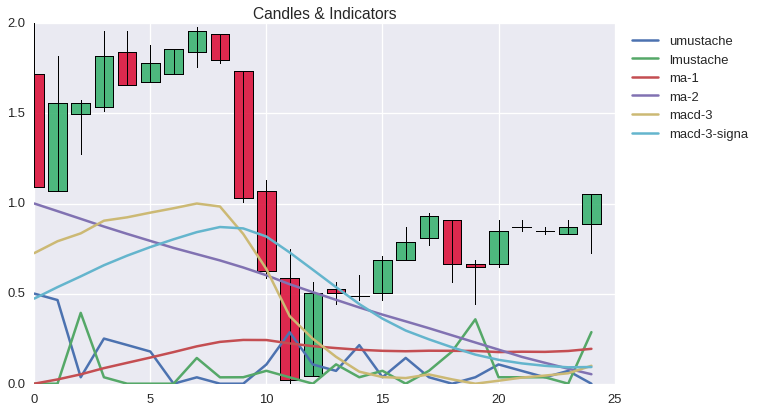

False


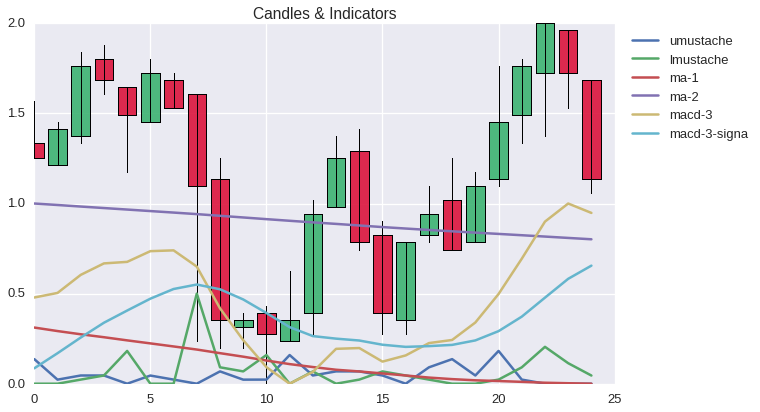

In [253]:
r = np.random.choice(range(len(real_data)))
print("True")
plot_ohlc_ind(real_data, r=r, indicators=indicators)
print("False")
plot_ohlc_ind(fake_data, r=r, indicators=indicators)

In [254]:
# Proper data generation
data = np.concatenate((real_data,fake_data)).astype(np.float32)
all_labels = np.array( [[1]]*len(real_data) + [[-1]]*len(fake_data) ).astype(np.int32)
# all_labels = np.array( [[1,0]]*len(real_data) + [[0,1]]*len(fake_data) ).astype(np.int32)
print(data.shape)
data = np.swapaxes(data,1,2)
print(data.shape)
data = np.reshape(data, data.shape + (1,))
print(data.shape)
# data = np.array(zip(train_test,all_labels))
print(all_labels.shape)

(406, 25, 10)
(406, 10, 25)
(406, 10, 25, 1)
(406, 1)


In [255]:
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t, train=True):
        y = self.predictor(x, train=train)
#         self.loss = F.sigmoid_cross_entropy(y, t) # softmax
        self.loss = F.mean_squared_error(y, t) # softmax
        return self.loss

In [256]:
USE_GPU = 1

def eval_net(network, x,y,eval_on=10,batch_size=400):
    
    tp,fp,tn,fn = 0,0,0,0
    
    N = x.shape[0]

    # Random permutations, permissive for N < batch_size
    perm = np.random.permutation(max(N,( batch_size / N + 1) * N)) % N
    np.random.shuffle(perm)
    perm = perm[:max(N,batch_size)]
    
    b = 0 if batch_size >= N else np.random.randint(0,N - batch_size)

    _examples = x[perm[b:b+batch_size]]
    _labels = y[perm[b:b+batch_size]]
        
    examples = Variable(_examples)
    examples.to_gpu(USE_GPU)

    pred = network( examples , train=False)
    pred.to_cpu()

    for idxi,i in enumerate(_labels):
        if np.sign(pred.data[idxi,0]) > 0:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true positive
                tp += 1
            else:
                # false positive
                fp += 1
        else:
            if np.sign(_labels[idxi])==np.sign(pred.data[idxi,0]):
                # true negative
                tn += 1
            else:
                # false negative
                fn += 1
                
    eval_on = float(batch_size)
    mean_loss = (tp+tn) / eval_on
    precision, recall = 0 if tp+fp==0 else tp/float(tp+fp), 0 if tp+fn==0 else tp/float(tp+fn)
    confusion_matrix  = [tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on]
    f1_score          = 0 if precision + recall==0 else 2 * ((precision * recall) / (precision + recall))# harmonic mean
    return mean_loss, precision, recall, f1_score, confusion_matrix

In [257]:
# initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotNormal(), scale=1.0)
# initializers.init_weight(cnn.l4.W.data, initializers.HeNormal(), scale=1.0)
# initializers.init_weight(cnn.l5.W.data, initializers.HeNormal(), scale=1.0)

# initializers.init_weight(cnn.c1_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.c2_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.c3_1.W.data, initializers.GlorotUniform(), scale=1.0)
# initializers.init_weight(cnn.l4.W.data, initializers.HeUniform(), scale=1.0)
# initializers.init_weight(cnn.l5.W.data, initializers.HeUniform(), scale=1.0)

# because ReLU
# cnn.c1_1.W.data += 0.05
# cnn.c2_1.W.data += 0.05
# cnn.c3_1.W.data += 0.05
# cnn.l4.W.data   += 0.05

In [258]:
def gpu_trainer(network, trainer, optimizer,
                x_train, x_test, y_train, y_test,
                n_steps = 100, batch_size = 400,
                log=True, display=True, print_nth=10):
    network.to_gpu(USE_GPU)
    trainer.to_gpu(USE_GPU)

    N = x_train.shape[0]

    if log:
        if display:
            print("> Training for %d steps"%n_steps)
            print("> Training samples: %d (%d positive). Testing samples: %d\n"%(len(y_train), np.sum(y_train+1)/2, len(y_test)))
            print("          (Accuracy) train , test   || (Precison/Recall) train , test ||  (F1_score) train , test")
            print("-"*100)
        print_nth = n_steps if (print_nth>n_steps) or (print_nth == -1) else print_nth
        p_every = n_steps/print_nth
        l = len(range(0,n_steps-1,p_every))
        log_train, log_test = np.zeros((l + 1,5)),np.zeros((l + 1,5))
        log_idx = 0

    for step in range(n_steps):
        network.zerograds()

        # Random permutations, permissive for N < batch_size
        perm = np.random.permutation(max(N,( batch_size / N + 1) * N)) % N
        np.random.shuffle(perm)
        perm = perm[:max(N,batch_size)]

        b = 0 if batch_size >= N else np.random.randint(0,N - batch_size)

        _examples = x_train[perm[b:b+batch_size]]
        _labels = y_train[perm[b:b+batch_size]]

        examples = Variable(_examples)
        labels = Variable(_labels.astype(np.float32)) #.astype(np.float32)
        examples.to_gpu(USE_GPU)
        labels.to_gpu(USE_GPU)

        optimizer.update(trainer,examples,labels)

        if log and (step%p_every==0 or step==n_steps-1):
            lo, pr, re, f1, cm      = eval_net(network, x_train,y_train,eval_on = 1, batch_size=400)
            lo_, pr_, re_, f1_, cm_ = eval_net(network, x_test, y_test, eval_on = 1, batch_size=400)
            log_train[log_idx] = np.array([step,lo, pr, re, f1])
            log_test[log_idx] = np.array([step,lo_, pr_, re_, f1_])
            log_idx += 1
            if display:
                print("Step %s:        %0.2f , %0.2f   ||\
     %0.2f/%0.2f , %0.2f/%0.2f      ||       %0.2f , %0.2f"
                  %(str(step).ljust(8),lo, lo_,pr,re,pr_,re_,f1,f1_))
    
    if log:
        return log_train, log_test, cm, cm_
    else:
        return None, None, None, None

In [259]:
l = int(len(data) * 0.8)
permut = np.random.permutation(len(data))
data = data[permut]
all_labels = all_labels[permut]
x_train , x_test = data[:l]   , data[l:]
y_train , y_test = all_labels[:l] , all_labels[l:]
print(len(x_train),len(x_test))
print(len(y_train),len(y_test))
print(np.sum(y_train+1)/2)

324 82
324 82
165


In [260]:
cnn = CNN_1D()
t_cnn = Train(cnn)

optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [261]:
%%time
log_train, log_test, cm, cm_ = gpu_trainer(cnn, t_cnn, optimizer, x_train, x_test, y_train, y_test,
                                           n_steps = 100, batch_size = 400,
                                           log=True, display=True, print_nth=25)

> Training for 100 steps
> Training samples: 324 (165 positive). Testing samples: 82

          (Accuracy) train , test   || (Precison/Recall) train , test ||  (F1_score) train , test
----------------------------------------------------------------------------------------------------
Step 0       :        0.51 , 0.47   ||     0.51/1.00 , 0.47/1.00      ||       0.68 , 0.63
Step 4       :        0.51 , 0.54   ||     0.00/0.00 , 0.00/0.00      ||       0.00 , 0.00
Step 8       :        0.64 , 0.65   ||     0.59/0.99 , 0.57/1.00      ||       0.74 , 0.73
Step 12      :        0.73 , 0.71   ||     0.66/0.96 , 0.62/0.92      ||       0.78 , 0.74
Step 16      :        0.76 , 0.79   ||     0.75/0.78 , 0.73/0.87      ||       0.77 , 0.79
Step 20      :        0.76 , 0.79   ||     0.72/0.86 , 0.72/0.89      ||       0.78 , 0.80
Step 24      :        0.76 , 0.77   ||     0.70/0.93 , 0.67/0.95      ||       0.80 , 0.79
Step 28      :        0.80 , 0.75   ||     0.74/0.97 , 0.66/0.95      ||      

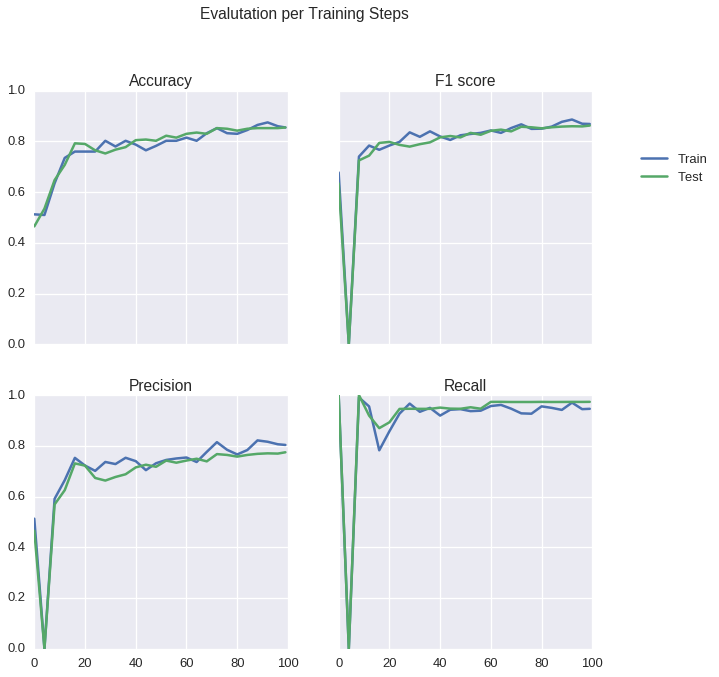

In [262]:
plot_scores(log_train, log_test, title='Evalutation per Training Steps')

== Final ==
Accuracy        :   train 0.848        , test 0.853
Precison/Recall :   train 0.789 0.938  , test 0.766 0.978
F1 score        :   train 0.857        , test 0.859


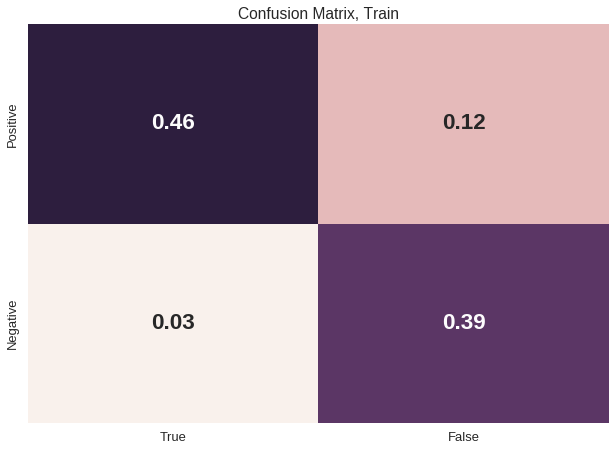

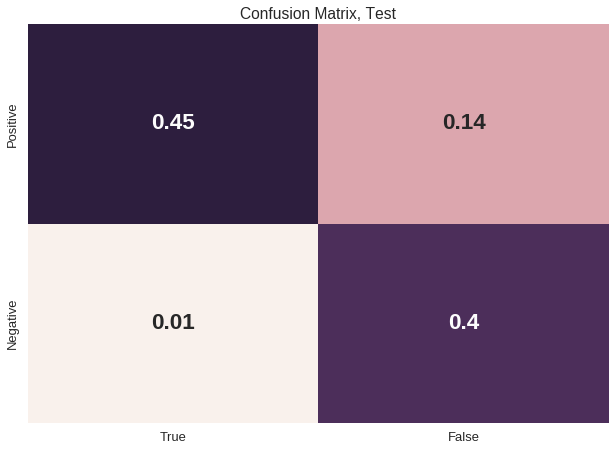

In [263]:
lo, pr, re, f1, cm     = eval_net(cnn, x_train,y_train,eval_on = 1, batch_size=400) # min(len(train)-1, 400)
lo_, pr_, re_, f1_, cm_ = eval_net(cnn, x_test,y_test,eval_on = 1, batch_size=400)
print("== Final ==\nAccuracy        :   train %0.3f        , test %0.3f\
\nPrecison/Recall :   train %0.3f %0.3f  , test %0.3f %0.3f\
\nF1 score        :   train %0.3f        , test %0.3f"
      %(lo, lo_,pr,re,pr_,re_,f1,f1_))
plot_confusion_matrix(cm ,title="Confusion Matrix, Train")
plot_confusion_matrix(cm_,title="Confusion Matrix, Test")

In [264]:
#serializers.save_hdf5("test_weights_cnn.h5",cnn)

In [265]:
def plot_scores(log_train, log_test, title='Evalutation per Training Steps'):
    f, ax = plt.subplots(2, 2, figsize=(10, 10),sharex=True,sharey=True)
    sns.despine(bottom=True)

    steps = log_train[:,0]

    ax[0,0].plot(steps,log_train[:,1],label="Train")
    ax[0,0].plot(steps,log_test[:,1],label="Test")
    ax[0,0].set_title('Accuracy')

    ax[1,0].plot(steps,log_train[:,2],label="Train")
    ax[1,0].plot(steps,log_test[:,2],label="Test")
    ax[1,0].set_title('Precision')

    ax[1,1].plot(steps,log_train[:,3],label="Train")
    ax[1,1].plot(steps,log_test[:,3],label="Test")
    ax[1,1].set_title('Recall')

    ax[0,1].plot(steps,log_train[:,4],label="Train")
    ax[0,1].plot(steps,log_test[:,4],label="Test")
    ax[0,1].set_title('F1 score')

    f.text(0.5, 1.0, title, ha='center')
    # f.text(0.5, 0.01, 'Training Steps', ha='center')
    # f.text(0.01, 0.5, 'Score', va='center', rotation='vertical')
    plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
    plt.legend(loc=1, bbox_to_anchor=(1.5, 2), ncol=1)
    plt.show()

In [266]:
def plot_confusion_matrix(cm,title="Confusion Matrix"):
    # cm = tp/eval_on,fp/eval_on,fn/eval_on,tn/eval_on
    sns.heatmap(np.reshape(cm,(2,2)),annot=True,
                xticklabels=["True","False"],yticklabels=["Positive","Negative"],
                cbar=False,
                annot_kws={"size":"x-large","weight":"bold"}
               )
    plt.title(title)
    plt.show()

In [267]:
def plot_ohlc_confidence(x,y,r=-1,indicators=indicators,mask_size=10):
    r = r if r!=-1 else np.random.randint(len(x))
        
    _example,_label = x[r], y[r]
    example = Variable(np.array([_example]))
    example.to_gpu(USE_GPU)
    pred = cnn( example )
    pred.to_cpu()
    pred = pred.data
    
    impact = []
    m2 = mask_size / 2

    for i in range(m2,_example.shape[1],mask_size):
        _mod = copy.deepcopy(_example)
        _mod[:,i-m2:i+m2,:] = 0.5 #np.random.rand(*_mod[i-m2:i+m2].shape)
        example = Variable(np.array([_mod]))
        example.to_gpu(USE_GPU)
        _pred = cnn( example )
        _pred.to_cpu()
        impact.append(pred - _pred.data[0,0])
    mask = np.repeat(impact,mask_size)
        
    c = copy.deepcopy(_example)
    c = np.swapaxes(c,1,0)
    c = np.reshape(c,(c.shape[0],c.shape[1]))
    for i in indicators_groups:
        if len(i) == 4:
            c[:,i] = c[:,i] * 2
        if i == [4,5] or i == [5,4]:
            c[:,i] = c[:,i] /2
#     c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
#     c[:,[4,5]] = c[:,[4,5]] /2
#     c[:,[6,7]] = c[:,[6,7]]
#     c[:,[8,9]] = c[:,[8,9]]

        
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)

    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,len(c[0])):
        plt.plot(c[:,i],label=indicators[i])
    plt.plot(mask,color="r",alpha=0.2,zorder=1)
    plt.fill_between(range(_example.shape[1]),mask,[0]*_example.shape[1],color="r",alpha=0.15,zorder=1,label="fuzzy interest")
    plt.title("Candles & Indicators (%s)"%r)
    plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
    
    ax.set_xlim(xmin=0)

    plt.show()
    
    print(_label, pred[0])
    print("Ok" if np.sign(_label[0])==np.sign(pred[0,0]) else "WRONG prediction")

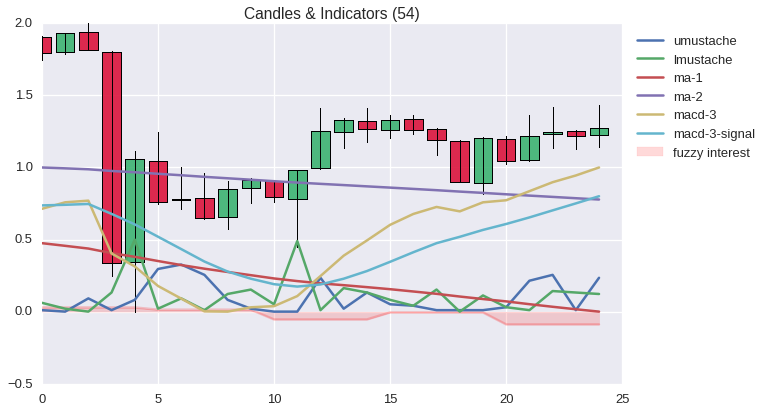

[-1] [-0.57985306]
Ok


In [268]:
# plot_ohlc_confidence(test,r=-1,mask_size=2)
plot_ohlc_confidence(x_test,y_test,r=-1,mask_size=5)

In [269]:
%%time

to_process = [] #np.zeros((ran,100,10))

# first_end = "2014/01/02 01:50" #dataset[0]
# last_end = "2014/12/30 11:10" #dataset[-1]
first_end = df.index[0].strftime("%Y-%m-%d %H:%M:%S")
last_end = df.index[-1].strftime("%Y-%m-%d %H:%M:%S")
idx_deb = df.index.get_loc(first_end)
idx_end = df.index.get_loc(last_end)
win = input_size

for i in range(idx_deb + win, idx_end):
    c = normalize_array(df[i-win:i])
    c = np.swapaxes(c,0,1)
    c = np.reshape(c, c.shape + (1,))
    to_process.append(c)
to_process = np.array(to_process)

CPU times: user 5min, sys: 4.05 s, total: 5min 4s
Wall time: 5min 4s


In [270]:
first_end

'2005-01-03 06:45:00'

In [271]:
last_end

'2016-07-07 06:50:00'

In [279]:
dff = copy.deepcopy(df[idx_deb+win:idx_end])
# dff = copy.deepcopy(df)
dff["y"] = np.zeros(len(dff))
for i in dataset:
    dff["y"][i["start"]:i["end"]] = 1

In [280]:
def output(arr):

    example = Variable(arr, volatile=True)
    example.to_gpu(USE_GPU)

    pred = cnn( example , train=False)
    pred.to_cpu()
    return pred.data

In [274]:
%%time
batch_size=400
over=len(to_process)
res = np.zeros(over)
for i in range(0,over,batch_size):
    res[i:i+batch_size] = output(to_process[i:i+batch_size])[:,0]

CPU times: user 7.6 s, sys: 120 ms, total: 7.72 s
Wall time: 7.71 s


In [281]:
mod_res = np.where(res >= 0.0,res,np.zeros(len(res)))

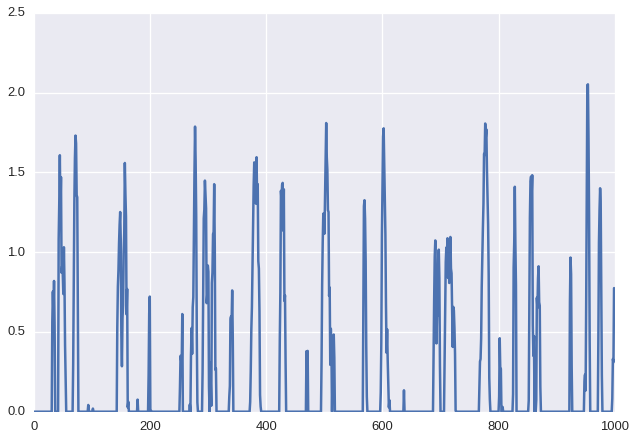

In [282]:
a = 0
b = a + 1000
# _plot_ohlc_ind([pandas_normalize(dff[a:b])])
plt.plot(mod_res[a:b] * 2)
plt.plot(dff["y"][a-100:b-100].values * 1.5)
# plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
plt.show()

In [283]:
len(dff)

852062

834583


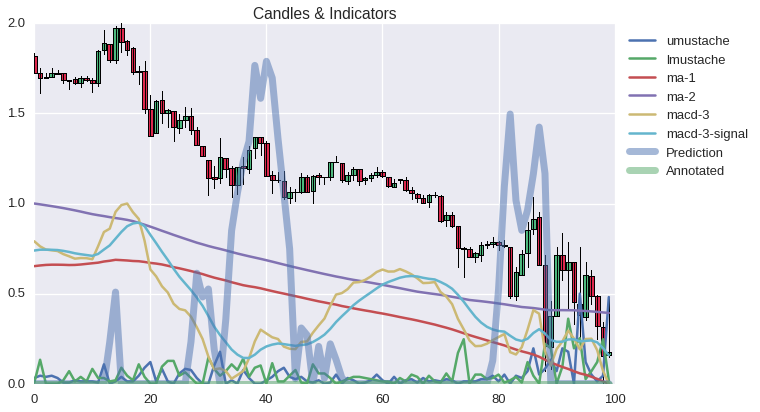

In [286]:
a = np.random.randint(100,len(mod_res)) # 149722
b = a + 100
print(a)
_plot_ohlc_ind([normalize_array(dff[a:b])])
plt.plot(mod_res[a:b]*2, label="Prediction",linewidth=7,alpha=0.5)
plt.plot(dff["y"][a-100:b-100].values * 1.5,label="Annotated",linewidth=7,alpha=0.5)
plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)
plt.show()

In [284]:
def _plot_ohlc_ind(selected_data,r=-1,indicators=indicators,labels=None):
    r = r if r!=-1 else np.random.choice(len(selected_data))
    c = copy.deepcopy(selected_data[r])
    for i in indicators_groups:
        if len(i) == 4:
            c[:,i] = c[:,i] * 2
        if i == [4,5] or i == [5,4]:
            c[:,i] = c[:,i] /2
#     c[:,[0,1,2,3]] = c[:,[0,1,2,3]] *2
#     c[:,[4,5]] = c[:,[4,5]] /2
#     c[:,[6,7]] = c[:,[6,7]]
#     c[:,[8,9]] = c[:,[8,9]]

    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)


    candlestick2_ohlc(ax, c[:,0], c[:,1], c[:,2], c[:,3], width=0.8,
                      colorup='mediumseagreen', colordown='crimson', alpha=0.9)

    for i in range(4,min(len(c[0])-1,10)):
        plt.plot(c[:,i],label=indicators[i])
    if not (labels is None):
        plt.plot(labels[r],'k--',label="Labels",linewidth=2)
    plt.title("Candles & Indicators")
#     plt.legend(loc=1, bbox_to_anchor=(1.25, 1), ncol=1)

    ax.set_xlim(xmin=0)

#     plt.show()

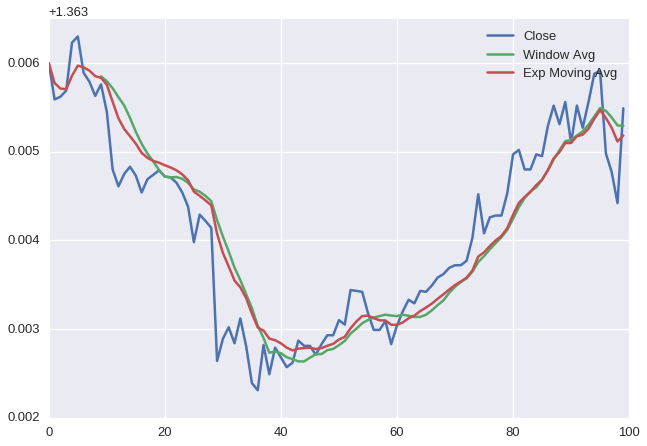

In [226]:
# Example pandas functions

plt.plot(df[0:100]["Close"].values,
        label="Close")
plt.plot(df[0:100]["Close"].rolling(window=10, min_periods=None, center=False).apply(lambda x: x.mean()).values,
        label="Window Avg")
plt.plot(df[0:100]["Close"].ewm(com=None, span=10, halflife=None, alpha=None,
       min_periods=0, freq=None, adjust=True, ignore_na=False, axis=0).mean().values,
        label="Exp Moving Avg")
# plt.plot(df[0:100]["Close"].expanding(min_periods=1, center=False).mean().values)
plt.legend()
plt.show()

In [229]:
cnn.to_cpu()
t_cnn.to_cpu()

143
{u'start': u'2014/09/15 19:05', u'end': u'2014/09/15 20:51', u'label': []}


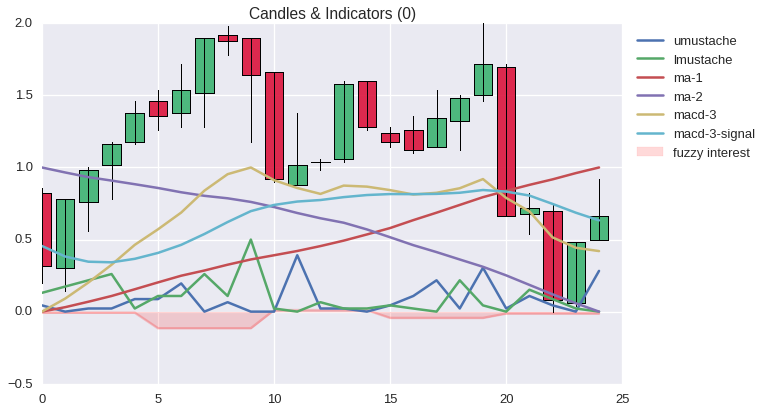

[1] [-0.98935962]
WRONG prediction
-10


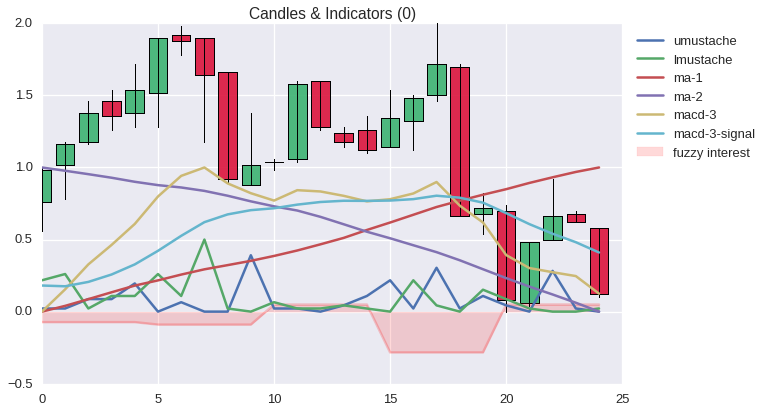

[1] [-0.93929452]
WRONG prediction
-8


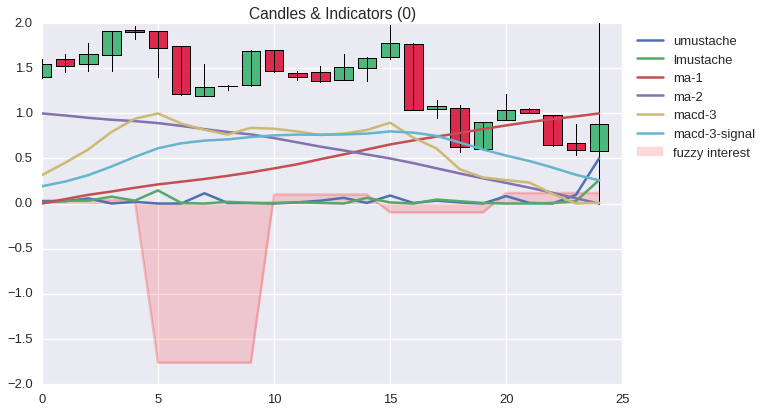

[1] [-0.86952895]
WRONG prediction
-6


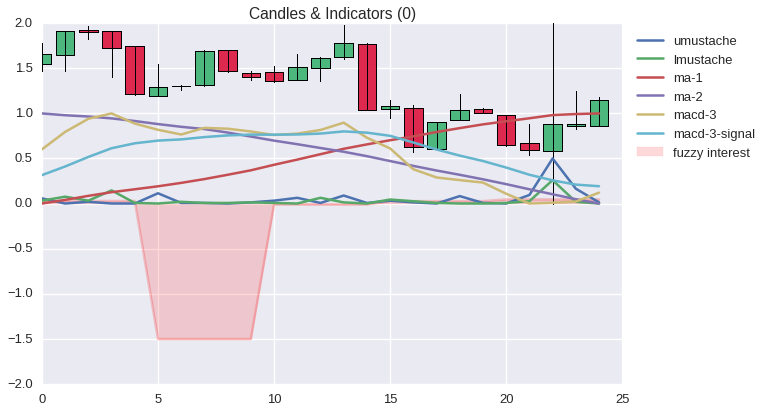

[1] [-0.95015877]
WRONG prediction
-4


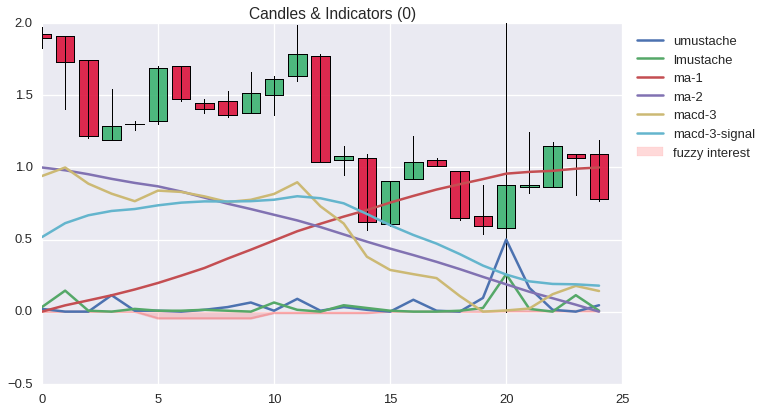

[1] [-0.99606454]
WRONG prediction
-2


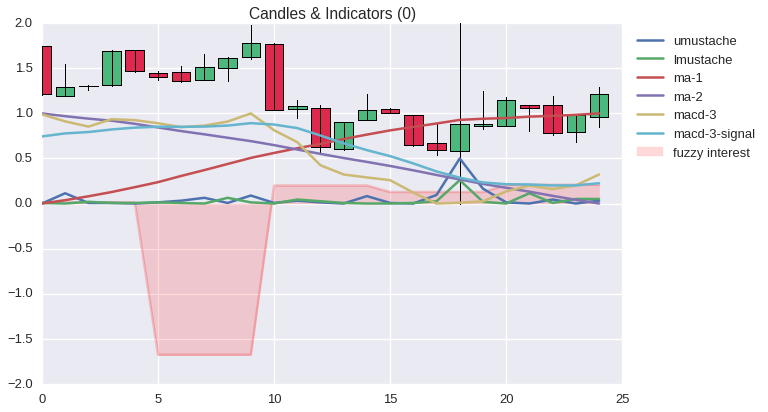

[1] [-0.78128338]
WRONG prediction
0


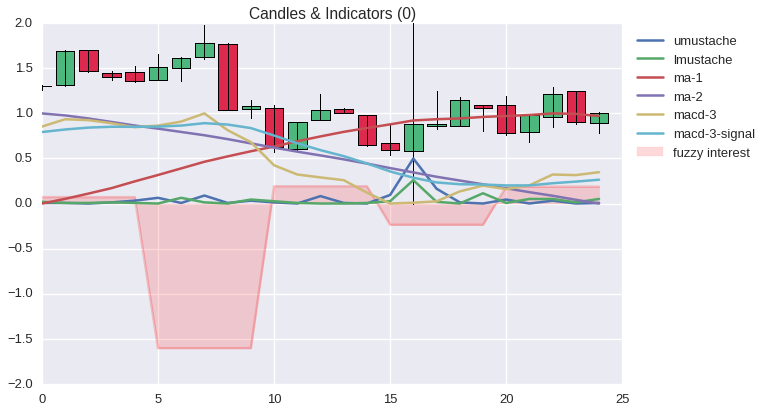

[1] [-0.80826223]
WRONG prediction
2


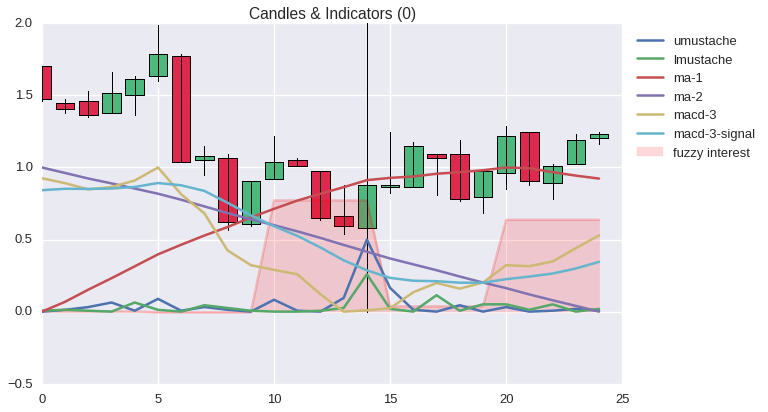

[1] [ 0.99375135]
Ok
4


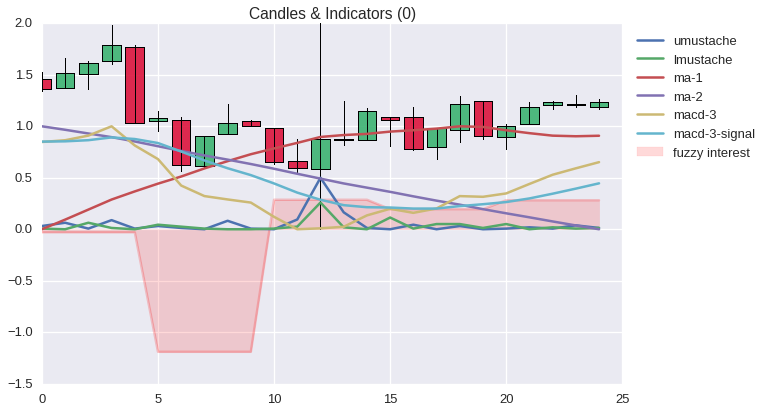

[1] [-0.71172869]
WRONG prediction
6


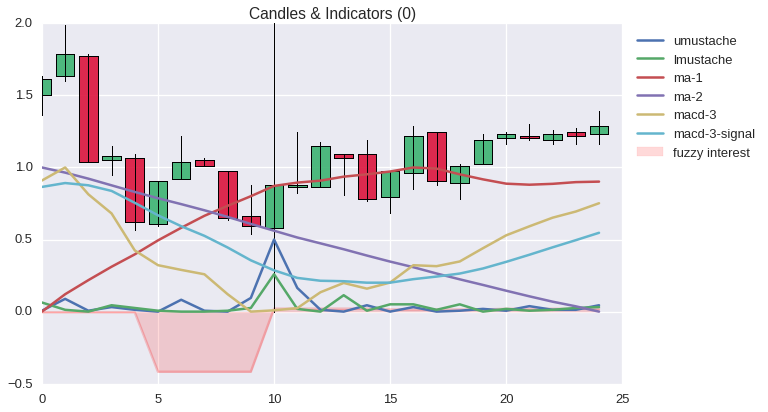

[1] [-0.97896248]
WRONG prediction
8


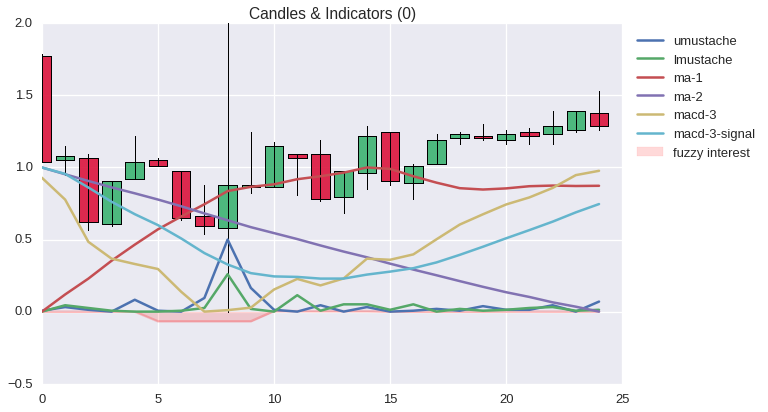

[1] [-0.99624485]
WRONG prediction
10


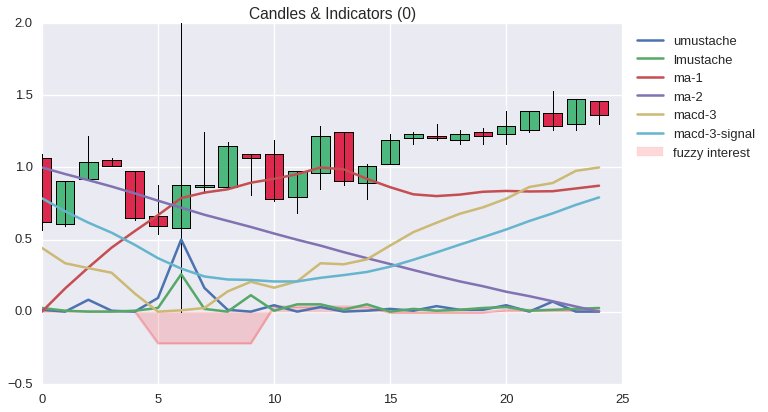

[1] [-0.96602249]
WRONG prediction
12


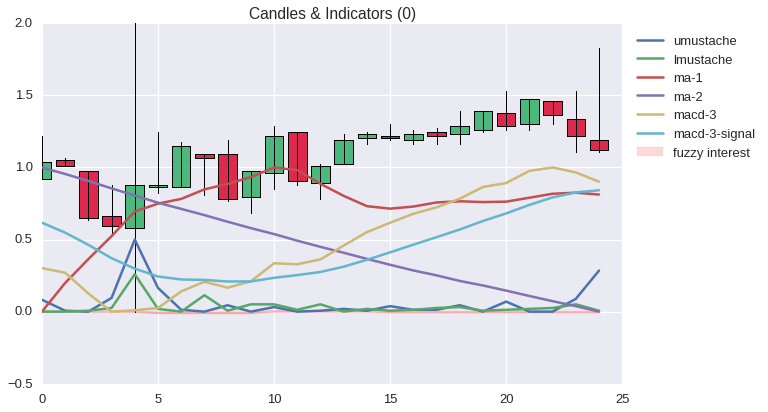

[1] [-0.99819511]
WRONG prediction
14


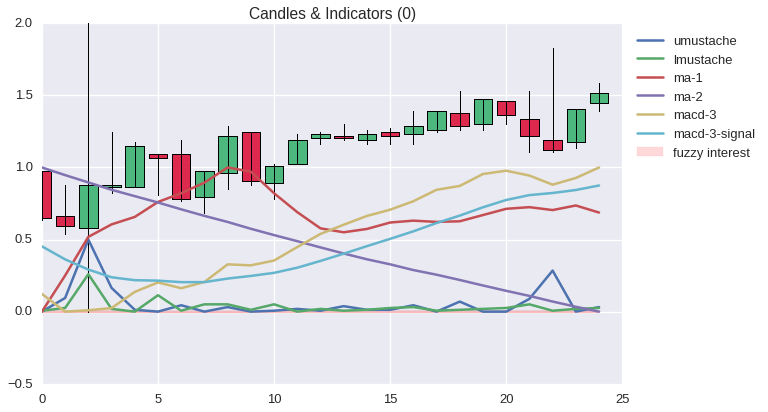

[1] [-0.99997121]
WRONG prediction
16


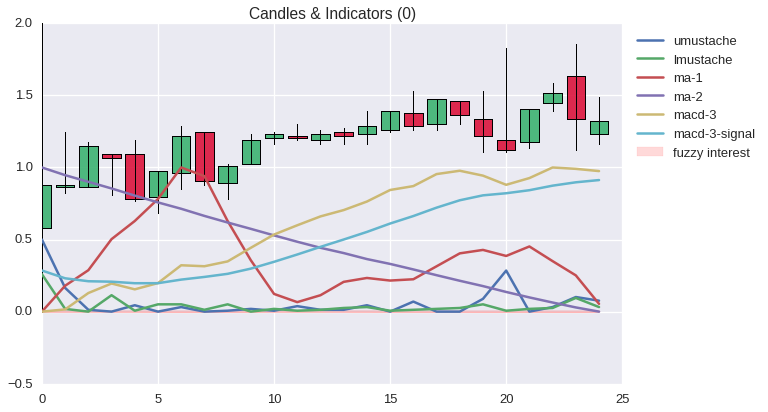

[1] [-0.99998295]
WRONG prediction
18


In [433]:
r = np.random.choice(range(len(dataset)))
print(r)
t = dataset[r]
print(t)
# t = {u's
idx = df.index.get_loc(str(t["end"])[:-1]+str(int(str(t["end"])[-1])-1))
t_start = df.index[idx - 200]

for i in range(-10,20,2):
    
    t_end = df.index[idx + i]
    
    t = {u'start': t_start, u'end': t_end, u'label': []}
    c,_ = select_normalize_from_df(t,
                 df,
                 input_size,
                 justify_right=False)
    c = np.swapaxes(c,0,1)
    c = np.reshape(c, (1,) + c.shape + (1,))
    
    plot_ohlc_confidence(c,y_test,r=-1,mask_size=5)  # adjust mask_size
    print(i)
    # plot_ohlc_ind([c,[-1]],r=0, indicators=indicators)

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---

---


---


---



---


---


---


---


---